# Introduction
**New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.
Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.
With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.
So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.**

# Data
**Data For this project we need the following data :
New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. Indian resturants in each neighborhood of new york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.**

# Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Indian Resturants.
- Find rating , tips and like count for each Indian Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

# Queries that can be answered using above dataset
- What is best location in New York City for Indian Cuisine ?
- Which areas have potential Indian Resturant Market ?
- Which all areas lack Indian Resturants ?
- Which is the best place to stay if I prefer Indian Cuisine ?

# Required Libraries
- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [2]:
import numpy as np

import pandas as pd 


import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'MFVV22KBMYZZVP4GGMBN5IXN1DDQIIPPM0SOLHCIC34C3GEK' 
    CLIENT_SECRET = 'ZIOQHRKZSQUB1IAL0DCQZ5LS45F1AYL3W1T5UUBUXXUR4VN0' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'MFVV22KBMYZZVP4GGMBN5IXN1DDQIIPPM0SOLHCIC34C3GEK' 
    CLIENT_SECRET = 'ZIOQHRKZSQUB1IAL0DCQZ5LS45F1AYL3W1T5UUBUXXUR4VN0'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape


(306, 4)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

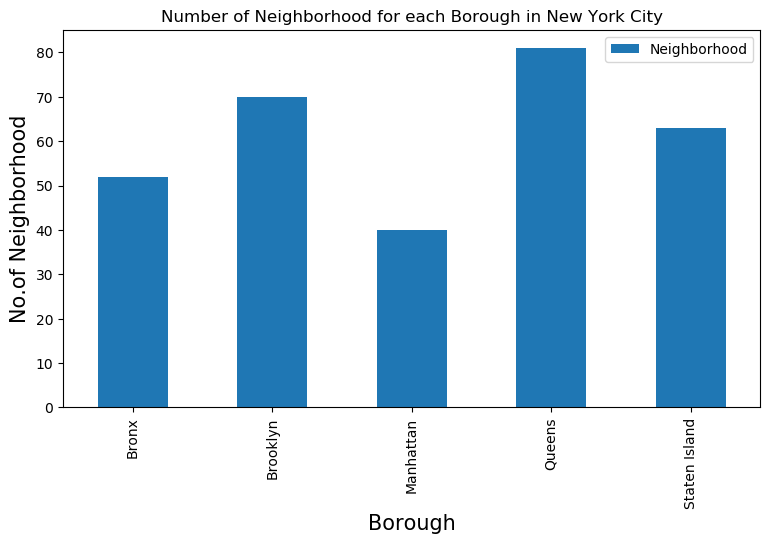

In [11]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [12]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

done
( 132 / 306 ) Indian Resturants in Jackson Heights, Queens:6
done
( 133 / 306 ) Indian Resturants in Elmhurst, Queens:3
done
( 134 / 306 ) Indian Resturants in Howard Beach, Queens:0
done
( 135 / 306 ) Indian Resturants in Corona, Queens:0
done
( 136 / 306 ) Indian Resturants in Forest Hills, Queens:0
done
( 137 / 306 ) Indian Resturants in Kew Gardens, Queens:2
done
( 138 / 306 ) Indian Resturants in Richmond Hill, Queens:8
done
( 139 / 306 ) Indian Resturants in Flushing, Queens:0
done
( 140 / 306 ) Indian Resturants in Long Island City, Queens:2
done
( 141 / 306 ) Indian Resturants in Sunnyside, Queens:1
done
( 142 / 306 ) Indian Resturants in East Elmhurst, Queens:0
done
( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
done
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
done
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
done
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
done
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
done
( 148 / 306 ) 

done
( 259 / 306 ) Indian Resturants in Elm Park, Staten Island:0
done
( 260 / 306 ) Indian Resturants in Remsen Village, Brooklyn:0
done
( 261 / 306 ) Indian Resturants in New Lots, Brooklyn:0
done
( 262 / 306 ) Indian Resturants in Paerdegat Basin, Brooklyn:0
done
( 263 / 306 ) Indian Resturants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Indian Resturants in Jamaica Hills, Queens:4
done
( 265 / 306 ) Indian Resturants in Utopia, Queens:0
done
( 266 / 306 ) Indian Resturants in Pomonok, Queens:0
done
( 267 / 306 ) Indian Resturants in Astoria Heights, Queens:1
done
( 268 / 306 ) Indian Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Indian Resturants in Concourse Village, Bronx:1
done
( 270 / 306 ) Indian Resturants in Mount Eden, Bronx:0
done
( 271 / 306 ) Indian Resturants in Mount Hope, Bronx:0
done
( 272 / 306 ) Indian Resturants in Sutton Place, Manhattan:2
done
( 273 / 306 ) Indian Resturants in Hunters Point, Queens:0
done
( 274 / 306 ) Indian Resturants in Turtle

In [13]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [14]:
indian_rest_ny.shape

(145, 4)

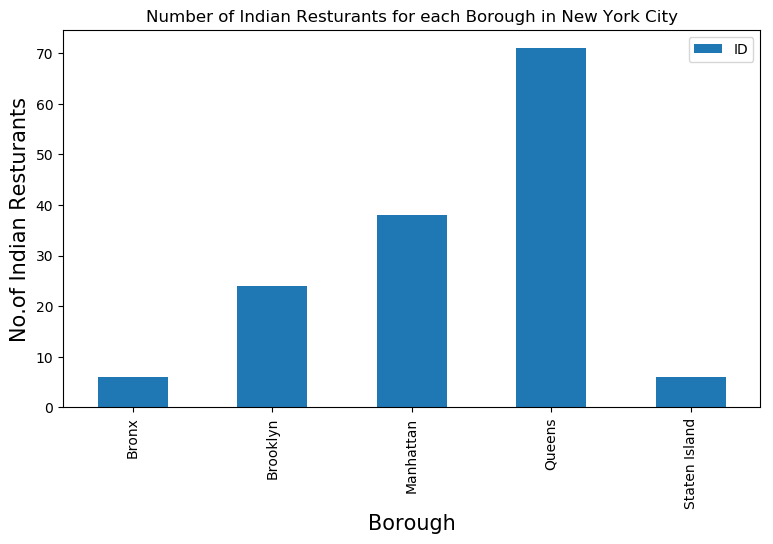

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

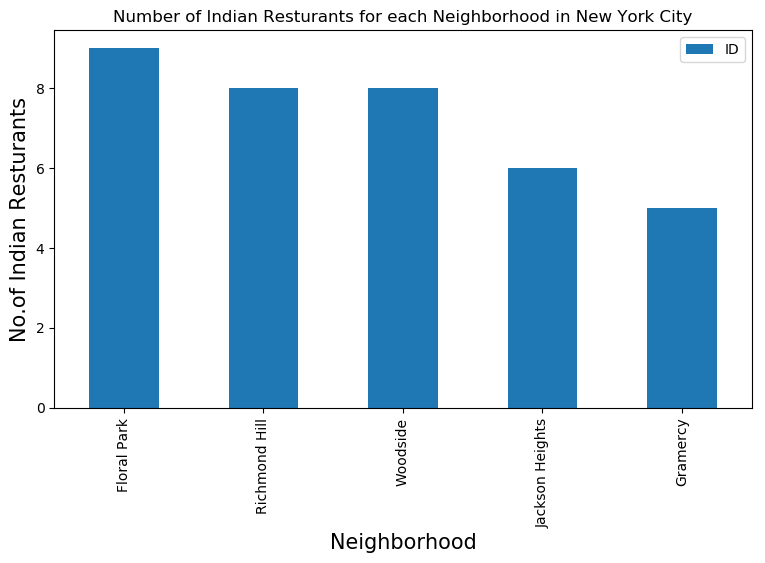

In [16]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,5d06c43cc03635002cc463f2,Honest
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [18]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.7    10
( 1 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 145 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 145 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 145 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     8.4    26
( 6 / 145 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [19]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [20]:
indian_rest_stats_ny.shape

(50, 7)

In [21]:
indian_rest_ny.shape

(145, 4)

In [22]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [23]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape

(50, 7)

In [24]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [25]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [26]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [27]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               9.1
Tips                                 148
Name: 41, dtype: object

In [28]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                               9.1
Tips                                 148
Name: 41, dtype: object

In [29]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                425
Rating                               8.7
Tips                                 161
Name: 47, dtype: object

In [31]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,9.100000
13,Greenwich Village,8.900000
4,Clinton Hill,8.800000
32,West Village,8.800000
10,Fort Greene,8.800000
3,Chelsea,8.700000
19,Murray Hill,8.700000
12,Gramercy,8.633333
8,East Village,8.600000
30,Upper West Side,8.550000


In [32]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.303846
1,Brooklyn,7.794737
0,Bronx,6.580000


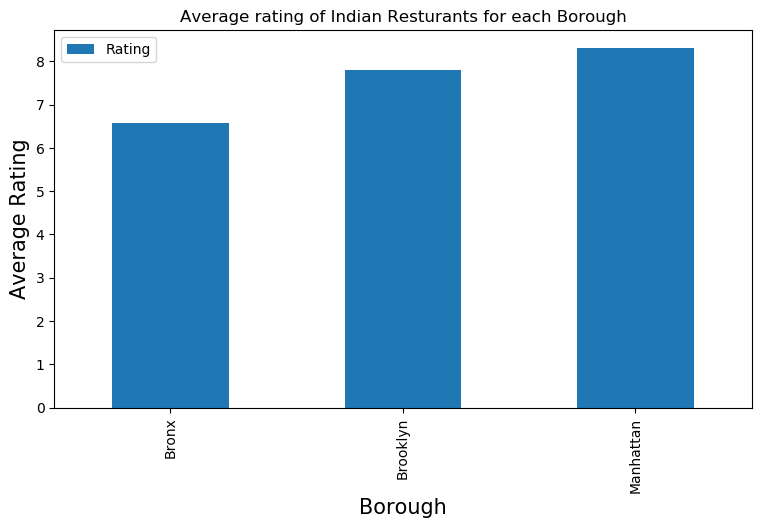

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
28,Tribeca,9.1


In [35]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.1


In [36]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [37]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [38]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)


# Conclusion
- Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.
- Manhattan have potential Indian Resturant Market
- Staten Island ranks last in average rating of Indian Resturants.
- Manhattan is the best place to stay if you prefer Indian Cuisine.
- Limitations
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare

## Limitations

- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare